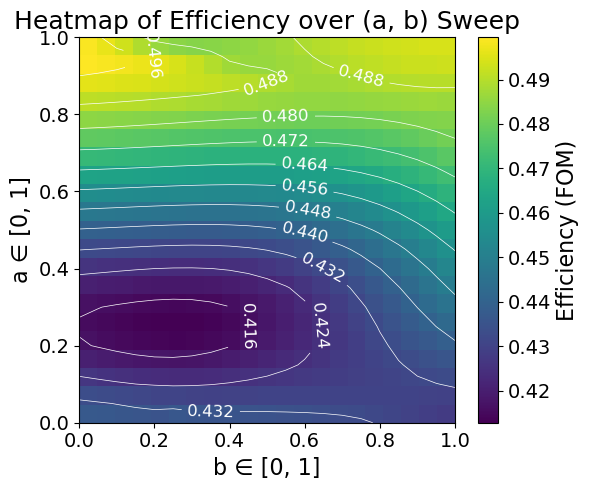

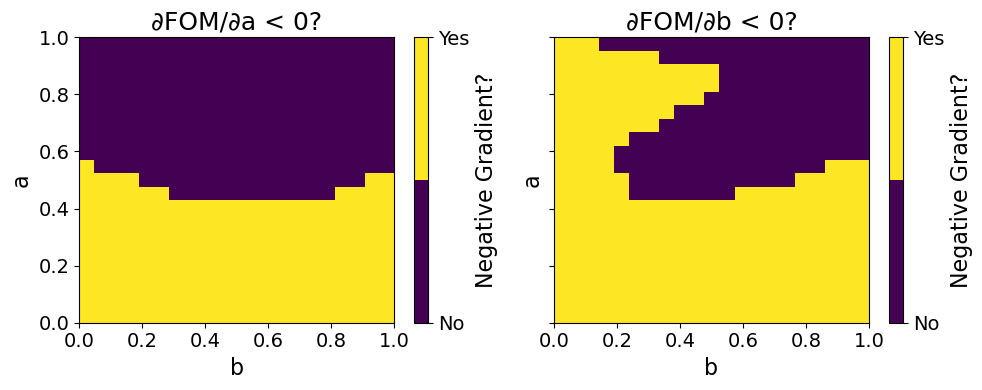

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# ───────────────────────────────────────────────────
# 1) Load sweep data
# ───────────────────────────────────────────────────
data       = np.load("sweep_results.npz")
effs       = data["effs"]       # shape (Na, Nb)
grad_a     = data["grad_a"]     # shape (Na, Nb)
grad_b     = data["grad_b"]     # shape (Na, Nb)
a_vals     = data["a_vals"]     # length Na
b_vals     = data["b_vals"]     # length Nb

# Create two boolean maps: True where gradient > 0, False otherwise
binary_a = grad_a > 0
binary_b = grad_b > 0

# Define a simple two‐color map (e.g. dark purple for False, yellow for True)
binary_cmap = ListedColormap(["#440154", "#FDE725"])  # Viridis endpoints

# ───────────────────────────────────────────────────
# 2) Plot efficiency heatmap (as before)
# ───────────────────────────────────────────────────
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(1, 1, 1)

im = ax.imshow(
    effs,
    origin='lower',
    aspect='auto',
    extent=(b_vals.min(), b_vals.max(), a_vals.min(), a_vals.max()),
    cmap='viridis'
)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Efficiency (FOM)", fontsize=16)
cbar.ax.tick_params(labelsize=14)

ax.set_xlabel("b ∈ [0, 1]", fontsize=16)
ax.set_ylabel("a ∈ [0, 1]", fontsize=16)
ax.set_title("Heatmap of Efficiency over (a, b) Sweep", fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)

# Optionally add contour lines on top
contours = ax.contour(
    b_vals, a_vals, effs,
    levels=10,
    colors='white',
    linewidths=0.5
)
ax.clabel(contours, inline=True, fontsize=12)

plt.tight_layout()
plt.show()

# ───────────────────────────────────────────────────
# 3) Plot two “yes/no” gradient maps side by side
# ───────────────────────────────────────────────────
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

# (∂FOM / ∂a) > 0 ?
im1 = ax1.imshow(
    binary_a.astype(int),  # 0 or 1
    origin='lower',
    aspect='auto',
    extent=(b_vals.min(), b_vals.max(), a_vals.min(), a_vals.max()),
    cmap=binary_cmap,
    vmin=0, vmax=1
)
ax1.set_title("∂FOM/∂a < 0?", fontsize=18)
ax1.set_xlabel("b", fontsize=16)
ax1.set_ylabel("a", fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=14)

# Create custom colorbar ticks labeled “No” / “Yes”
cbar1 = fig2.colorbar(im1, ax=ax1, ticks=[0, 1])
cbar1.ax.set_yticklabels(["No", "Yes"], fontsize=14)
cbar1.set_label("Negative Gradient?", fontsize=16)

# (∂FOM / ∂b) > 0 ?
im2 = ax2.imshow(
    binary_b.astype(int),
    origin='lower',
    aspect='auto',
    extent=(b_vals.min(), b_vals.max(), a_vals.min(), a_vals.max()),
    cmap=binary_cmap,
    vmin=0, vmax=1
)
ax2.set_title("∂FOM/∂b < 0?", fontsize=18)
ax2.set_xlabel("b", fontsize=16)
ax2.set_ylabel("a", fontsize=16)
ax2.tick_params(axis='both', which='major', labelsize=14)

cbar2 = fig2.colorbar(im2, ax=ax2, ticks=[0, 1])
cbar2.ax.set_yticklabels(["No", "Yes"], fontsize=14)
cbar2.set_label("Negative Gradient?", fontsize=16)

plt.tight_layout()
plt.show()


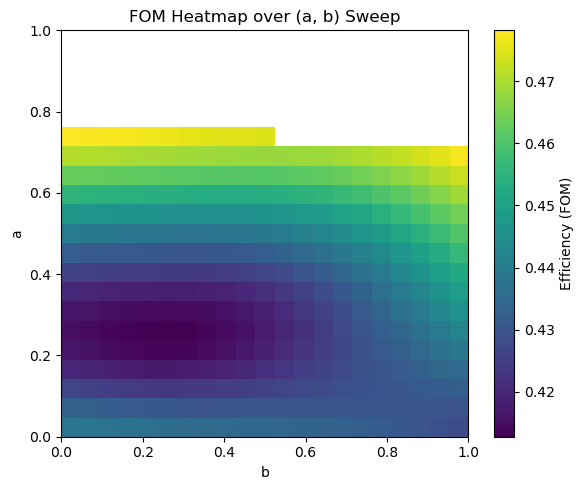

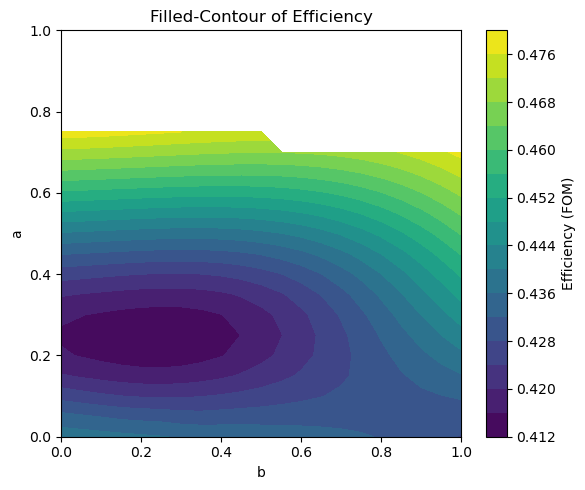

133 134


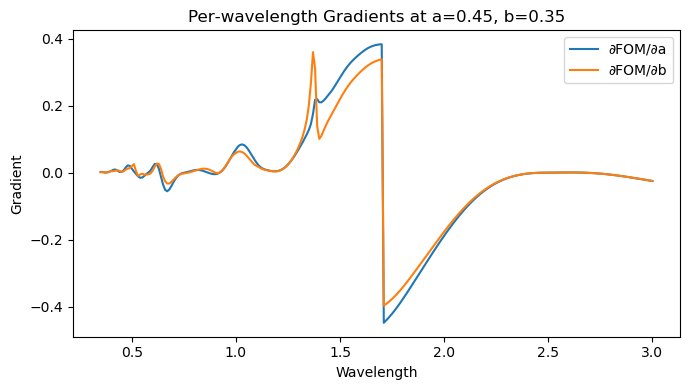

102 134


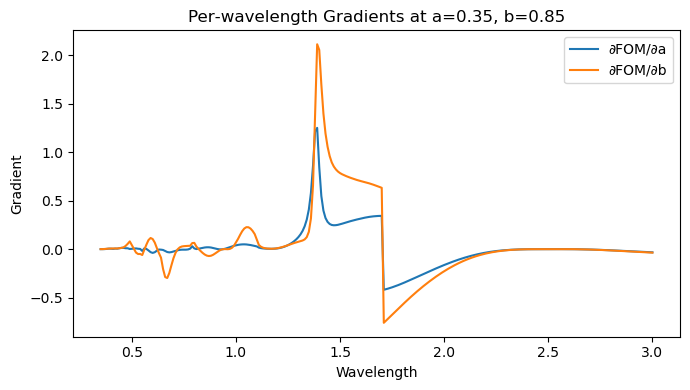

133 134


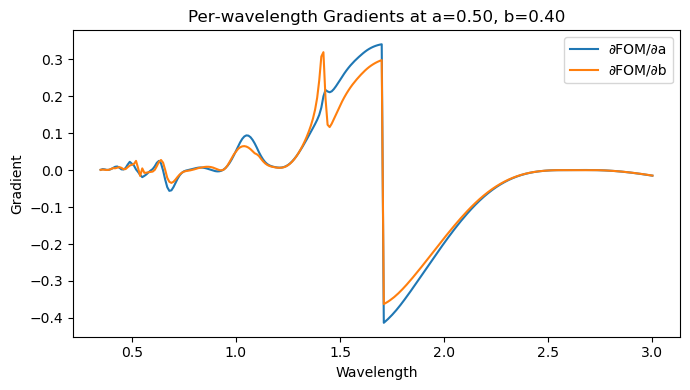

101 134


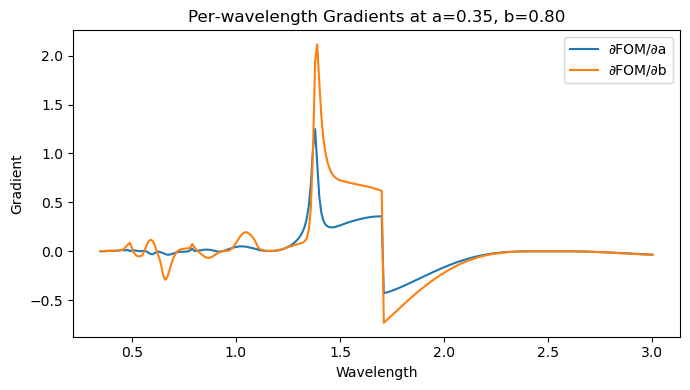

In [2]:
import os, re
import numpy as np
import matplotlib.pyplot as plt

# ─── 1) Load the 2D FOM heatmap ───────────────────────────────────────
heatmap_file = "heatmaps.npz"   # or "sweep_results.npz" if you didn't rename
data = np.load(heatmap_file)
effs   = data["effs"]    # shape (Na, Nb)
a_vals = data["a_vals"]  # length Na
b_vals = data["b_vals"]  # length Nb
Na, Nb = effs.shape

# ─── 2) Plot FOM heatmap ─────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(
    effs,
    origin='lower',
    aspect='auto',
    extent=(b_vals.min(), b_vals.max(), a_vals.min(), a_vals.max()),
    cmap='viridis'
)
ax.set_title("FOM Heatmap over (a, b) Sweep")
ax.set_xlabel("b")
ax.set_ylabel("a")
fig.colorbar(im, ax=ax, label="Efficiency (FOM)")
plt.tight_layout()
plt.show()

# ─── 3) Filled‐contour of the same ───────────────────────────────────
fig, ax = plt.subplots(figsize=(6,5))
cf = ax.contourf(b_vals, a_vals, effs, levels=20)
ax.set_title("Filled‐Contour of Efficiency")
ax.set_xlabel("b")
ax.set_ylabel("a")
fig.colorbar(cf, ax=ax, label="Efficiency (FOM)")
plt.tight_layout()
plt.show()

# ─── 4) Discover which (a,b) subfolders actually exist ───────────────
results_root = "results"
folders = []
for dname in os.listdir(results_root):
    if not dname.startswith("a_"): continue
    fpath = os.path.join(results_root, dname)
    if not os.path.isdir(fpath): continue
    ai, bj = map(float, dname[2:].split("_b_"))
    i = int(np.argmin(np.abs(a_vals - ai)))
    j = int(np.argmin(np.abs(b_vals - bj)))
    folders.append((i, j, fpath))
# ─── 5) Grab the common wavelengths array ────────────────────────────
first_folder = folders[0][2]
pw0 = np.load(os.path.join(first_folder, "per_wavelength_data.npz"))
wls = pw0["wavelengths"]  # shape (n_wl,)
n_wl = len(wls)

# ─── 6) Pick 3 random wavelengths ────────────────────────────────────
# rng = np.random.default_rng(0)
# sel = rng.choice(n_wl, size=3, replace=False)
sel = np.random.rand(3)

# ─── pick one (a,b) to visualize its per‐wavelength gradients ────────
# e.g. take the first folder in your list:
for h in range(min(len(folders),5)):
    i0, j0, folder0 = folders[h]
    d0 = np.load(os.path.join(folder0, "per_wavelength_data.npz"))
    wls      = d0["wavelengths"]   # shape (n_sampled_wl,)
    if "grad_a_wl" not in d0.keys():
        continue
    grad_a_wl= d0["grad_a_wl"]
    grad_b_wl= d0["grad_b_wl"]

    # ─── plot them as 1D curves ─────────────────────────────────────────
    plt.figure(figsize=(7,4))
    plt.plot(wls, grad_a_wl, label="∂FOM/∂a")
    plt.plot(wls, grad_b_wl, label="∂FOM/∂b")
    plt.xlabel("Wavelength")
    plt.ylabel("Gradient")
    plt.title(f"Per‐wavelength Gradients at a={a_vals[i0]:.2f}, b={b_vals[j0]:.2f}")
    print(np.argmax(grad_a_wl),np.argmin(grad_a_wl))
    plt.legend()
    plt.tight_layout()
    plt.show()

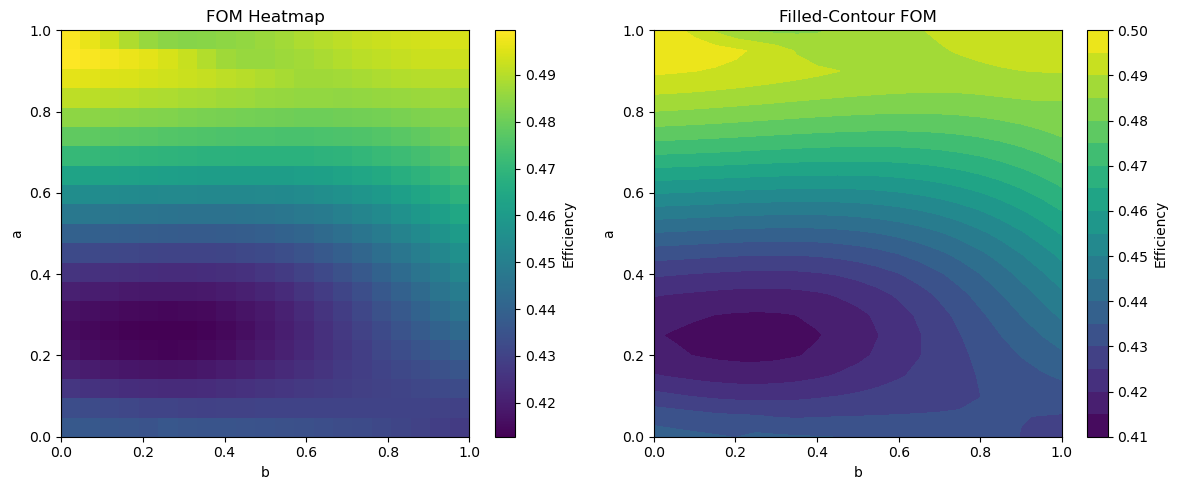

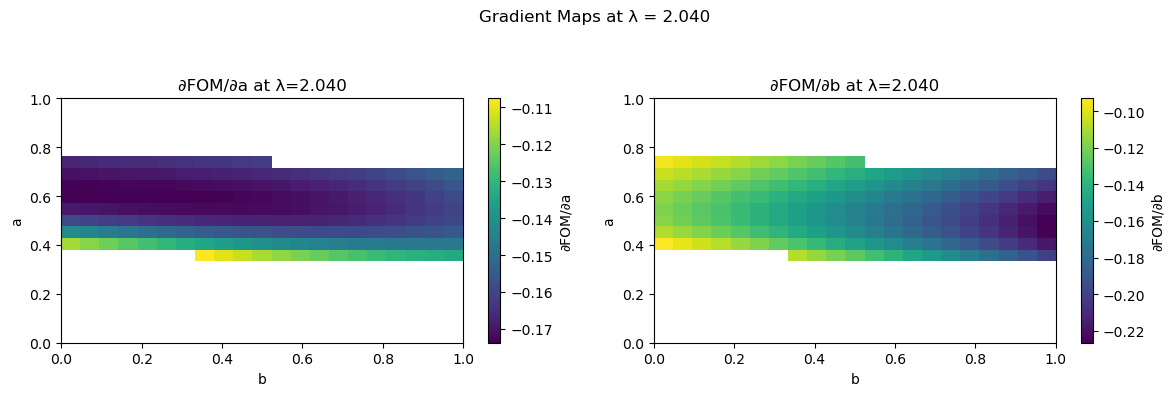

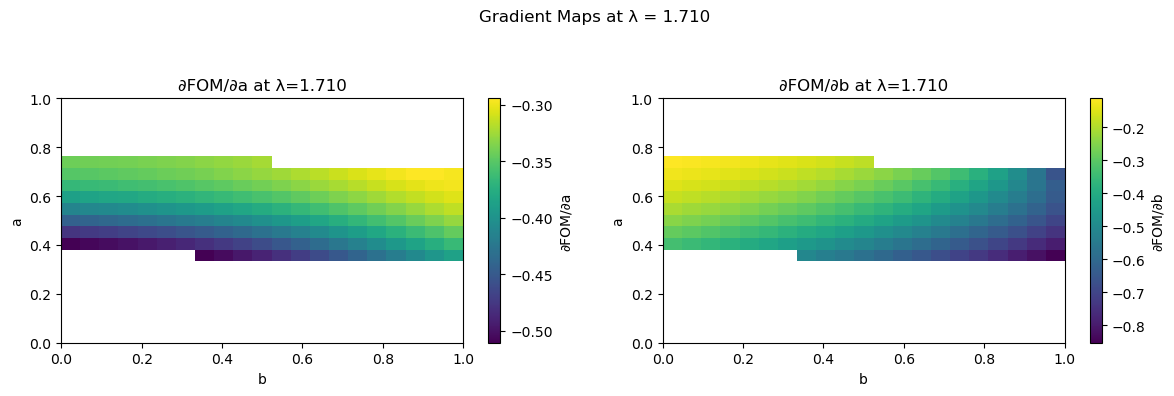

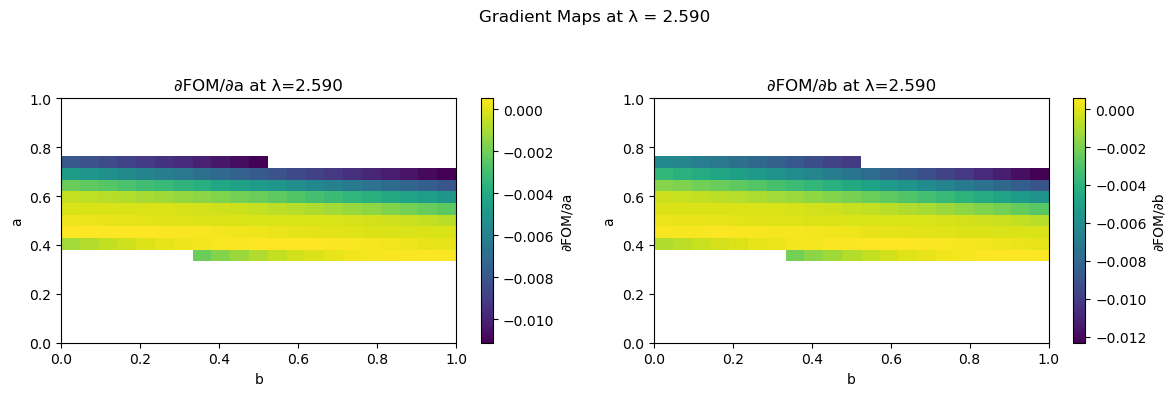

In [29]:
import os, re
import numpy as np
import matplotlib.pyplot as plt

# ─── 1) Load the 2D FOM heatmap ───────────────────────────────────────
npz = np.load("sweep_results.npz")
effs   = npz["effs"]    # shape (Na, Nb)
a_vals = npz["a_vals"]  # length Na
b_vals = npz["b_vals"]  # length Nb
Na, Nb = effs.shape

# ─── 2) Plot Efficiency heatmap + filled-contour ────────────────────
fig, ax = plt.subplots(1,2,figsize=(12,5))
im = ax[0].imshow(effs, origin='lower', aspect='auto',
                  extent=(b_vals.min(),b_vals.max(),a_vals.min(),a_vals.max()),
                  cmap='viridis')
ax[0].set(title="FOM Heatmap", xlabel="b", ylabel="a")
fig.colorbar(im, ax=ax[0], label="Efficiency")

cf = ax[1].contourf(b_vals, a_vals, effs, levels=20)
ax[1].set(title="Filled‐Contour FOM", xlabel="b", ylabel="a")
fig.colorbar(cf, ax=ax[1], label="Efficiency")
plt.tight_layout()
plt.show()

# ─── 3) Discover all (a,b) subfolders ─────────────────────────────────
results_root = "results"
pattern = re.compile(r"a_(?P<a>[\d\.]+)_b_(?P<b>[\d\.]+)")
folders = []
for d in os.listdir(results_root):
    m = pattern.fullmatch(d)
    if not m: continue
    ai, bj = float(m.group("a")), float(m.group("b"))
    i = int(np.argmin(np.abs(a_vals - ai)))
    j = int(np.argmin(np.abs(b_vals - bj)))
    folders.append((i, j, os.path.join(results_root, d)))

# ─── 4) Grab the sampled wavelengths ─────────────────────────────────
_,_,first = folders[0]
first_npz = np.load(os.path.join(first, "per_wavelength_data.npz"))
wls = first_npz["wavelengths"]   # (n_wl,)
n_wl = len(wls)

# ─── 5) Pick 3 random wavelengths ────────────────────────────────────
rng = np.random.default_rng(0)
sel = rng.choice(n_wl, size=3, replace=False)

# ─── 6) For each λ build + plot ∂FOM/∂a and ∂FOM/∂b heatmaps ────────
for idx in sel:
    lam = wls[idx]
    grad_a_map = np.full((Na, Nb), np.nan)
    grad_b_map = np.full((Na, Nb), np.nan)

    for (i, j, folder) in folders:
        path = os.path.join(folder, "per_wavelength_data.npz")
        d = np.load(path)

        # ─── skip any folder that hasn't been updated yet ─────────────
        if "grad_a_wl" not in d or "grad_b_wl" not in d:
            continue

        # now safe to index
        grad_a_map[i, j] = d["grad_a_wl"][idx]
        grad_b_map[i, j] = d["grad_b_wl"][idx]

    # … rest of your plotting code remains unchanged …


    # plot side-by-side
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
    im1 = ax1.imshow(grad_a_map, origin='lower', aspect='auto',
                     extent=(b_vals.min(),b_vals.max(),a_vals.min(),a_vals.max()))
    ax1.set(title=f"∂FOM/∂a at λ={lam:.3f}", xlabel="b", ylabel="a")
    fig.colorbar(im1, ax=ax1, label="∂FOM/∂a")

    im2 = ax2.imshow(grad_b_map, origin='lower', aspect='auto',
                     extent=(b_vals.min(),b_vals.max(),a_vals.min(),a_vals.max()))
    ax2.set(title=f"∂FOM/∂b at λ={lam:.3f}", xlabel="b", ylabel="a")
    fig.colorbar(im2, ax=ax2, label="∂FOM/∂b")

    plt.suptitle(f"Gradient Maps at λ = {lam:.3f}")
    plt.tight_layout(rect=[0,0,1,0.92])
    plt.show()


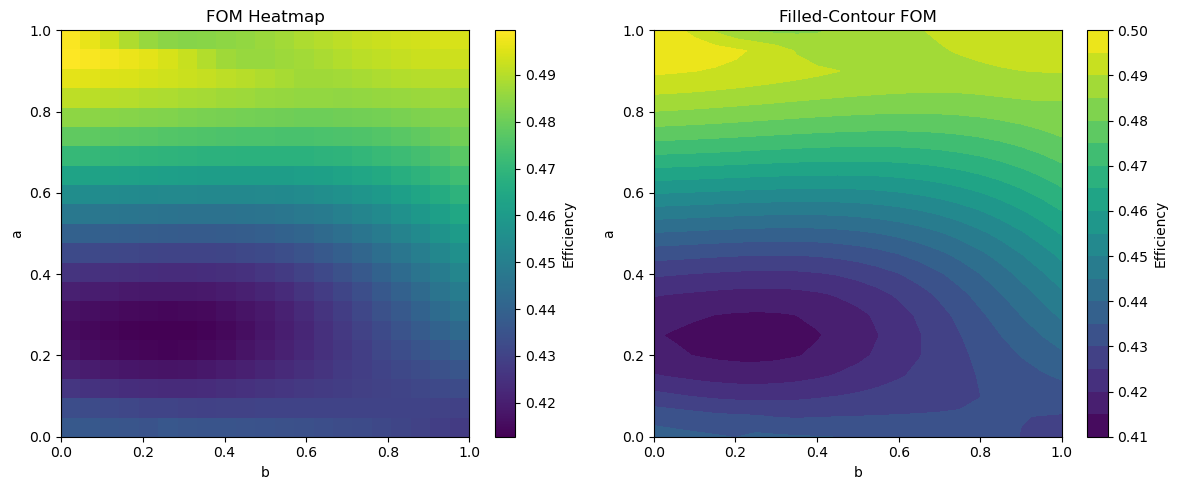

KeyError: 'grad_a_wl is not a file in the archive'

In [1]:
import os, re
import numpy as np
import matplotlib.pyplot as plt

# ─── 1) Load the 2D FOM heatmap ───────────────────────────────────────
npz = np.load("sweep_results.npz")
effs   = npz["effs"]    # shape (Na, Nb)
a_vals = npz["a_vals"]  # length Na
b_vals = npz["b_vals"]  # length Nb
Na, Nb = effs.shape

# ─── 2) Plot Efficiency heatmap + filled-contour ────────────────────
fig, ax = plt.subplots(1,2,figsize=(12,5))
im = ax[0].imshow(effs, origin='lower', aspect='auto',
                  extent=(b_vals.min(),b_vals.max(),a_vals.min(),a_vals.max()),
                  cmap='viridis')
ax[0].set(title="FOM Heatmap", xlabel="b", ylabel="a")
fig.colorbar(im, ax=ax[0], label="Efficiency")

cf = ax[1].contourf(b_vals, a_vals, effs, levels=20)
ax[1].set(title="Filled‐Contour FOM", xlabel="b", ylabel="a")
fig.colorbar(cf, ax=ax[1], label="Efficiency")
plt.tight_layout()
plt.show()

# ─── 3) Discover all (a,b) subfolders ─────────────────────────────────
results_root = "results"
pattern = re.compile(r"a_(?P<a>[\d\.]+)_b_(?P<b>[\d\.]+)")
folders = []
for d in os.listdir(results_root):
    m = pattern.fullmatch(d)
    if not m: continue
    ai, bj = float(m.group("a")), float(m.group("b"))
    i = int(np.argmin(np.abs(a_vals - ai)))
    j = int(np.argmin(np.abs(b_vals - bj)))
    folders.append((i, j, os.path.join(results_root, d)))

# ─── 4) Grab the sampled wavelengths ─────────────────────────────────
_,_,first = folders[0]
first_npz = np.load(os.path.join(first, "per_wavelength_data.npz"))
wls = first_npz["wavelengths"]   # (n_wl,)
n_wl = len(wls)

# ─── 5) Pick 3 random wavelengths ────────────────────────────────────
rng = np.random.default_rng(0)
sel = rng.choice(n_wl, size=3, replace=False)

# ─── 6) For each λ build + plot ∂FOM/∂a and ∂FOM/∂b heatmaps ────────
for idx in sel:
    lam = wls[idx]
    grad_a_map = np.full((Na, Nb), np.nan)
    grad_b_map = np.full((Na, Nb), np.nan)

    # fill maps from each folder’s saved grad_a_wl/grad_b_wl
    for (i,j,folder) in folders:
        d = np.load(os.path.join(folder, "per_wavelength_data.npz"))
        grad_a_map[i,j] = d["grad_a_wl"][idx]
        grad_b_map[i,j] = d["grad_b_wl"][idx]

    # plot side-by-side
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
    im1 = ax1.imshow(grad_a_map, origin='lower', aspect='auto',
                     extent=(b_vals.min(),b_vals.max(),a_vals.min(),a_vals.max()))
    ax1.set(title=f"∂FOM/∂a at λ={lam:.3f}", xlabel="b", ylabel="a")
    fig.colorbar(im1, ax=ax1, label="∂FOM/∂a")

    im2 = ax2.imshow(grad_b_map, origin='lower', aspect='auto',
                     extent=(b_vals.min(),b_vals.max(),a_vals.min(),a_vals.max()))
    ax2.set(title=f"∂FOM/∂b at λ={lam:.3f}", xlabel="b", ylabel="a")
    fig.colorbar(im2, ax=ax2, label="∂FOM/∂b")

    plt.suptitle(f"Gradient Maps at λ = {lam:.3f}")
    plt.tight_layout(rect=[0,0,1,0.92])
    plt.show()


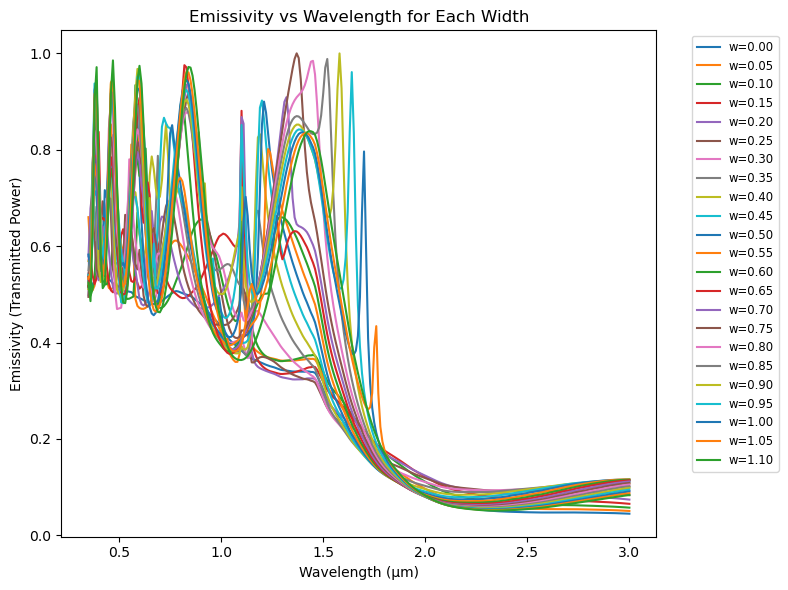

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Load the sweep results
data = np.load("width_sweep.npz", allow_pickle=True)
width_vals = data["width_vals"]
emiss_stack = data["emiss_profiles"]  # shape: (N_widths, N_samples)

# Recompute the wavelengths and sampling indices exactly as in the sweep
wavelengths = torch.linspace(0.35, 3, 2651).numpy()
exclude = {0.5, 1.0}
jump = 10
indices_used = [i for i, wl in enumerate(wavelengths) if (i % jump == 0 and wl not in exclude)]
plot_wl = wavelengths[indices_used]  # wavelengths for each sampled point

# Plot emissivity profiles
plt.figure(figsize=(8, 6))
for i, w in enumerate(width_vals):
    plt.plot(plot_wl, emiss_stack[i], label=f"w={w:.2f}")

plt.xlabel("Wavelength (µm)")
plt.ylabel("Emissivity (Transmitted Power)")
plt.title("Emissivity vs Wavelength for Each Width")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize="small")
plt.tight_layout()
plt.show()


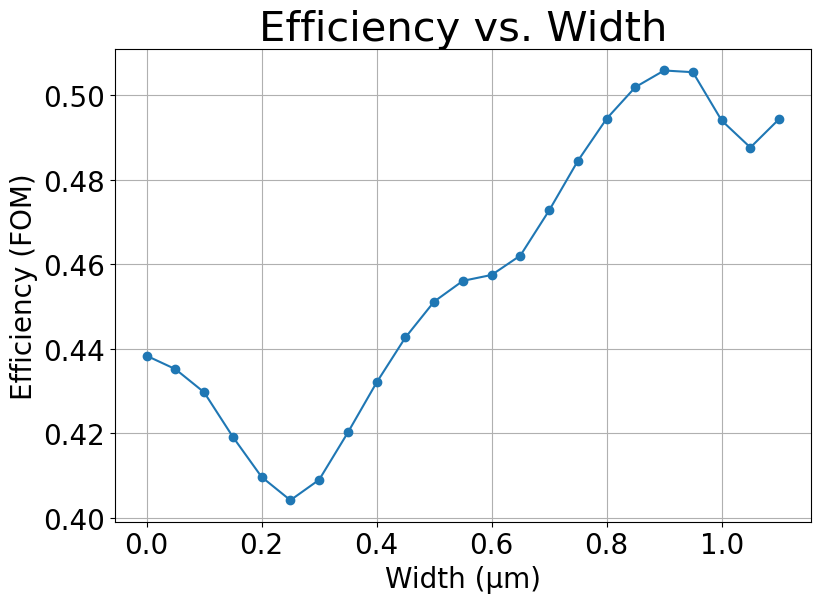

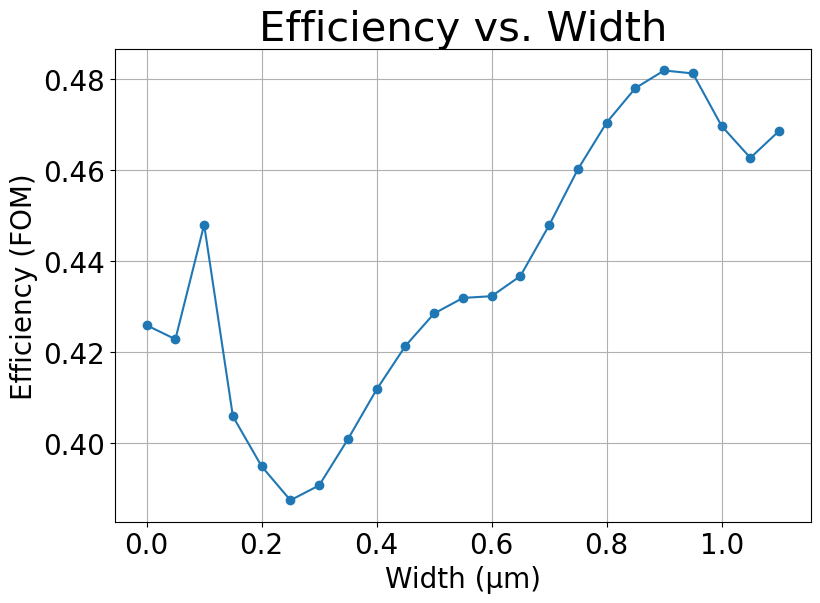

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Load sweep results
for i in ["", ".v2"]:
    data = np.load(f"width_sweep{i}.npz")
    width_vals = data["width_vals"]
    effs = data["effs"]

    # Plot efficiency vs. width
    plt.figure(figsize=(8, 6))
    plt.plot(width_vals, effs, marker='o')
    plt.xlabel("Width (µm)",fontsize=20)
    plt.ylabel("Efficiency (FOM)",fontsize=20)
    plt.title("Efficiency vs. Width",fontsize=30)
    plt.grid(True)
    plt.tight_layout()
    plt.tick_params(labelsize=20)
    plt.show()
